In [2]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime

In [85]:
U = 1
H = 0.5
L = H
nx = 50
dx = (L) / (nx + 1)
d = 3 * dx

config = {
    'domain': {
        'minExtent': -3 * H,
        'maxExtent': 3 * H,
        'dim': 2,
        'periodic': False
    },
    'particle': {
        'nx': nx,
        'dx': dx,
    },
    'compute':{
        'device': 'cuda'
    },
    'fluid':{
        'cs' : 100 * U
    },
    'shifting':{
        'scheme': 'deltaPlus',
        'maxIterations': 1,
        'threshold': 0.025,
        'surfaceScaling' : 1.0,
        'freeSurface': True
    },
    'gravity':{
        'active': False
    }
}
config = parseDefaultParameters(config)
config = parseModuleParameters(config)

# display(config)

In [86]:
# from diffSPH.v2.sdf import getSDF, operatorDict
# from diffSPH.v2.plotting import *
# ngrid = 255
# x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
# y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
# X, Y = torch.meshgrid(x, y, indexing = 'ij')
# P = torch.stack([X,Y], dim=-1)
# points = P.reshape(-1,2)

# sphere_a = lambda points: getSDF('circle')['function'](points, R)
# sdf = sphere_a
# plotSDF(sdf(torch.clone(points.to('cuda')),), X.to('cuda'), Y.to('cuda'), 2, 2)

In [87]:
particleStateA, mask = sampleParticles(config, sdfs = [], 
    minExtent = [-H + config['particle']['dx'] / 2,  0 + config['particle']['dx'] / 2 + d/2], 
    maxExtent = [ H - config['particle']['dx'] / 2,  L - config['particle']['dx'] / 2 + d/2])

particleStateB, mask = sampleParticles(config, sdfs = [], 
    minExtent = [-H + config['particle']['dx'] / 2,  -L + config['particle']['dx'] / 2 - d/2], 
    maxExtent = [ H - config['particle']['dx'] / 2,  0 - config['particle']['dx'] / 2 - d/2])

particleStateA['fluidVelocities'][:,1] = -U
particleStateB['fluidVelocities'][:,1] = U

particleState = {}
particleState['numParticles'] = particleStateA['numParticles'] + particleStateB['numParticles']
particleState['timestep'] = min(particleStateA['timestep'], particleStateB['timestep'])
particleState['time'] = 0
particleState['dt'] = min(particleStateA['dt'], particleStateB['dt'])
for k in particleStateA.keys():
    if isinstance(particleStateA[k], torch.Tensor):
        particleState[k] = torch.cat([particleStateA[k], particleStateB[k]], dim = 0)

In [88]:
printState(particleState)

state[numParticles            ]:      10100	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:          0	[<class 'int'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -5.049e-01, max: +5.049e-01, median: +0.000e+00 [torch.Size([10100, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +9.612e-05, max: +9.612e-05, median: +9.612e-05 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +9.612e-02, max: +9.612e-02, median: +9.612e-02 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +3.720e-02, max: +3.720e-02, median: +3.720e-02

In [104]:
perennialState = copy.deepcopy(particleState)

priorState = None
config['diffusion']['velocityScheme'] = 'deltaSPH_inviscid'
config['diffusion']['nu'] = 0.01
config['diffusion']['alpha'] = 0.01
config['timestep']['minDt'] = 1e-6

# perennialState['fluidVelocities'][:,0] =  A * perennialState['fluidPositions'][:,0]
# perennialState['fluidVelocities'][:,1] = -A * perennialState['fluidPositions'][:,1]
perennialState['fluidNeighborhood'] = fluidNeighborSearch(perennialState, config)

In [105]:
printState(perennialState)

state[numParticles            ]:      10100	[<class 'int'>]
state[timestep                ]:          0	[<class 'int'>]
state[time                    ]:          0	[<class 'int'>]
state[dt                      ]:      0.001	[<class 'float'>]
state[fluidPositions          ]: min: -5.049e-01, max: +5.049e-01, median: +0.000e+00 [torch.Size([10100, 2])	@ cuda:0	x torch.float32	]
state[fluidAreas              ]: min: +9.612e-05, max: +9.612e-05, median: +9.612e-05 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidPressures          ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidDivergence         ]: min: +0.000e+00, max: +0.000e+00, median: +0.000e+00 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidMasses             ]: min: +9.612e-02, max: +9.612e-02, median: +9.612e-02 [torch.Size([10100])	@ cuda:0	x torch.float32	]
state[fluidSupports           ]: min: +3.720e-02, max: +3.720e-02, median: +3.720e-02

In [106]:

# from diffSPH.v2.modules.pressureForce import computePressureAccelSwitch
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne

# from diffSPH.v2.modules.neighborhood import fluidNeighborSearch
# from diffSPH.v2.sphOps import sphOperationFluidState
# from diffSPH.v2.util import countUniqueEntries
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceBarecasco
# from diffSPH.v2.math import pinv2x2, scatter_sum
# from diffSPH.v2.sphOps import sphOperation, sphOperationFluidState
# from diffSPH.v2.math import scatter_sum
# from diffSPH.v2.modules.densityDiffusion import renormalizedDensityGradient, computeDensityDeltaTerm
# from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
# from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
# from diffSPH.v2.modules.viscosity import computeViscosity
# from diffSPH.v2.modules.pressureEOS import computeEOS
# from diffSPH.v2.modules.pressureForce import computePressureAccel
# from diffSPH.v2.modules.gravity import computeGravity


# def simulationStep(simulationState, config, diffusion = 'yes'):
#     simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
#     _, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])
    
#     simulationState['fluidL'], _, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)
#     simulationState['fluidGradRho^L'] = renormalizedDensityGradient(simulationState, config)
#     # simulationState['fluidGradRho'] = sphOperationFluidState(simulationState, (simulationState['fluidDensities'], simulationState['fluidDensities']), operation = 'gradient', gradientMode='difference')
    
#     simulationState['fluidDensityDiffusion'] = computeDensityDeltaTerm(simulationState, config)
#     simulationState['fluidMomentumEquation'] = computeMomentumEquation(simulationState, config)

#     simulationState['fluidVelocityDiffusion'] = computeViscosity(simulationState, config)
#     simulationState['fluidPressures'] = computeEOS(simulationState, config)

#     if config['deltaSPH']['pressureSwitch']:
#         # simulationState['fluidNormals'], simulationState['fluidLambdas'] = computeNormalsMaronne(simulationState, config)
#         simulationState['fluidFreeSurface']= detectFreeSurfaceBarecasco(simulationState, config)
#         (i,j) = simulationState['fluidNeighborhood']['indices']
#         numParticles = simulationState['numParticles']
#         simulationState['fluidSurfaceMask'] = scatter_sum(simulationState['fluidFreeSurface'][j], i, dim = 0, dim_size = numParticles)
#         simulationState['fluidPressureAccel'] = computePressureAccelSwitch(simulationState, config)
#     else:
#         simulationState['fluidPressureAccel'] = computePressureAccel(simulationState, config)

#     simulationState['fluidDivergence'] = sphOperationFluidState(simulationState, (simulationState['fluidVelocities'], simulationState['fluidVelocities']), 'divergence')

#     simulationState['fluidGravityAccel'] = computeGravity(simulationState, config) #/ simulationState['fluidMasses'].unsqueeze(-1)

#     dudt = simulationState['fluidPressureAccel'] + simulationState['fluidGravityAccel']
#     drhodt = simulationState['fluidMomentumEquation']

#     if diffusion == 'yes':
#         dudt += simulationState['fluidVelocityDiffusion']
#         drhodt += simulationState['fluidDensityDiffusion']
#     elif diffusion == 'only':
#         dudt = simulationState['fluidVelocityDiffusion']
#         drhodt = simulationState['fluidDensityDiffusion']
#     elif diffusion == 'no':
#         pass
    
#     return simulationState['fluidVelocities'].clone(), dudt, drhodt


In [107]:
display(config['diffusion'])

{'delta': 0.1,
 'densityScheme': 'deltaSPH',
 'velocityScheme': 'deltaSPH_inviscid',
 'nu': 0.01,
 'alpha': 0.01,
 'beta': 0.0,
 'pi-switch': False,
 'artificial-constant': 0.02,
 'eps': 1e-06}

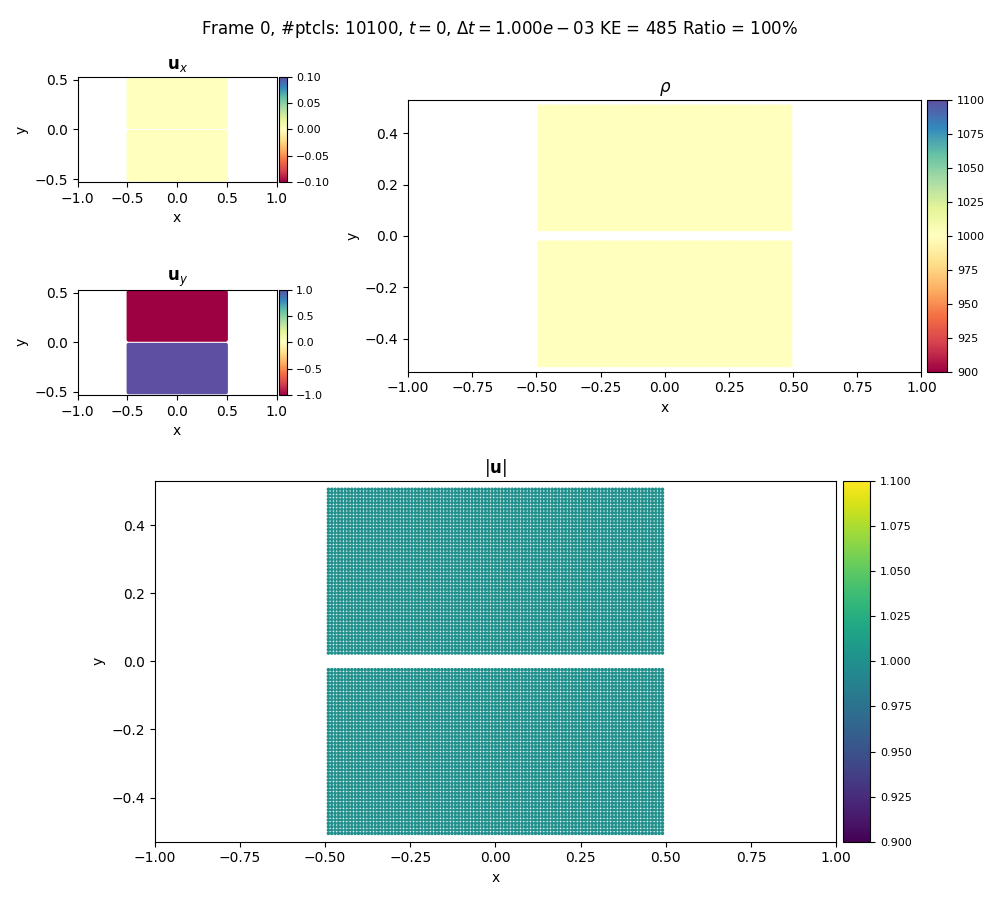

In [108]:
s = 2.5

fig, axis = plt.subplot_mosaic('''ACC
                               BCC
                               DDD
                               DDD
                               ''', figsize=(10,9), sharex = False, sharey = False)

visualizationState = prepVisualizationState(perennialState, config)
# val = perennialState['fluidPressures'] / perennialState['fluidDensities'] * omega**2 * (2/3)**2
# plotStateIndex = visualizeParticles(fig, axis['A'], config, visualizationState, val , cbar = True, cmap = 'YlGnBu', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'$P/\rho\omega^2L^2$')

val = particleState['fluidNumNeighbors']

initialVelocity = particleState['fluidVelocities'].clone()
initialVelocity[:,0] =  0
initialVelocity[:,1] = -U

initialKineticEnergy = 0.5 * particleState['fluidAreas'] * particleState['fluidDensities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
initialPotentialEnergy = 0

kineticEnergy = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2

# plotNumNeighbors = visualizeParticles(fig, axis['A'], config, visualizationState, particleState['fluidNumNeighbors'] , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = .1, mapping = '.x')
# axis['A'].set_title(r'Num Neighbors')


plotVelocityDensity = visualizeParticles(fig, axis['C'], config, visualizationState, perennialState['fluidDensities'] , cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = config['fluid']['rho0'], gridVisualization= False, s = s, mapping = '.x')
axis['C'].set_title(r'$\rho$')

plotVelocityU = visualizeParticles(fig, axis['A'], config, visualizationState, perennialState['fluidVelocities'][:,0] , cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['A'].set_title(r'$\mathbf{u}_x$')
plotVelocityY = visualizeParticles(fig, axis['B'], config, visualizationState, perennialState['fluidVelocities'][:,1] , cbar = True, cmap = 'Spectral', scaling = 'sym', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['B'].set_title(r'$\mathbf{u}_y$')

plotVelocityMag = visualizeParticles(fig, axis['D'], config, visualizationState, torch.linalg.norm(perennialState['fluidVelocities'], dim = -1) , cbar = True, cmap = 'viridis', scaling = 'lin', midPoint = 0, gridVisualization= False, s = s, mapping = '.x')
axis['D'].set_title(r'$|\mathbf{u}|$')

fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t = {perennialState["time"]:.3g}$, $\Delta t = {perennialState["dt"]:.3e}$ KE = {kineticEnergy.sum().item():.3g} Ratio = {(kineticEnergy.sum().item() / initialKineticEnergy.sum().item())*100:.3g}%''')

axis['A'].set_aspect('equal')
axis['B'].set_aspect('equal')
axis['C'].set_aspect('equal')
axis['D'].set_aspect('equal')
axis['A'].set_xlim(-2*H, 2*H)
axis['A'].set_ylim(-L - d, L + d)
axis['B'].set_xlim(-2*H, 2*H)
axis['B'].set_ylim(-L - d, L + d)
axis['C'].set_xlim(-2*H, 2*H)
axis['C'].set_ylim(-L - d, L + d)
axis['D'].set_xlim(-2*H, 2*H)
axis['D'].set_ylim(-L - d, L + d)

fig.tight_layout()

In [109]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
outFolder = './output/' + timestamp + '/'
os.makedirs(outFolder, exist_ok = True)

timeLimit = 0.5

pbar = tqdm(total=int(timeLimit * 1000))

KEs = []
PEs = []

while True:
    perennialState, *priorState = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluidPositions'] += dx
    # Frame done, update state for next timestep
    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    perennialState['dt'] = config['timestep']['dt']
    config['timestep']['dt'] = computeTimestep(perennialState, config)
    time = perennialState['time']
    dt = config['timestep']['dt']
    kineticEnergy = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
    potentialEnergy = 0 
    KEs.append(kineticEnergy.sum().cpu().item())
    PEs.append(0)
    pbar.n = int(time  * 1000)
    pbar.refresh()
    pbar.set_description(f"t = {time:.3g}, dt = {dt:.3e}, KE = {kineticEnergy.sum().cpu().item():.3g}, PE = {potentialEnergy:.3g}, Difference = {((kineticEnergy.sum()) - (initialKineticEnergy.sum() + initialPotentialEnergy)).cpu().item() / (initialKineticEnergy.sum() + initialPotentialEnergy).cpu().item() * 100:.3g}%")
    if time > timeLimit:
        break
    if perennialState['timestep'] > 720:
        break

    if perennialState["timestep"] % 1 == 0:
        fig.suptitle(rf'''Frame {perennialState["timestep"]}, #ptcls: {perennialState["numParticles"]}, $t = {perennialState["time"]:.3g}$, $\Delta t = {perennialState["dt"]:.3e}$  KE = {kineticEnergy.sum().item():.3g}''')
        
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(plotVelocityU, visualizationState, perennialState['fluidVelocities'][:,0])
        updatePlot(plotVelocityY, visualizationState, perennialState['fluidVelocities'][:,1])
        updatePlot(plotVelocityMag, visualizationState, torch.linalg.norm(perennialState['fluidVelocities'], dim = -1))
        updatePlot(plotVelocityDensity, visualizationState, perennialState['fluidDensities'])
        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(outFolder + 'frame_{:04d}.png'.format(perennialState["timestep"]), dpi = 300)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [112]:
import subprocess
import shlex
output = 'RectangleImpact'
scale = 640

command = '/usr/bin/ffmpeg -loglevel warning -hide_banner -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r 30 ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps=30,scale={scale}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps=30,scale={scale}:-1:flags=lanczos[x];[x][1:v]paletteuse" {timestamp if output == "timestamp" else output}.gif'

print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
subprocess.run(shlex.split(command))
print('Creating gif palette')
subprocess.run(shlex.split(commandB))
print('Creating gif')
subprocess.run(shlex.split(commandC))
print('Done')

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from './output/2024_03_08-09_05_18/output.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.29.100
  Duration: 00:00:06.03, start: 0.000000, bitrate: 19033 kb/s
    Stream #0:0(und): Video: h264 (High 4:4:4 Predictive) (avc1 / 0x31637661), yuv444p, 3000x2700 [SAR 1:1 DAR 10:9], 19028 kb/s, 60 fps, 60 tbr, 15360 tbn, 120 tbc (default)
    Metadata:
      handler_name    : VideoHandler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> png (native))
Press [q] to stop, [?] for help
Output #0, image2, to './output/2024_03_08-09_05_18/palette.png':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(und): Video: png, rgba, 16x16 [SAR 1:1 DAR 1:1], q=2-31, 200 kb/s, 30 fps, 30 tbn, 30 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encode

CompletedProcess(args=['ffmpeg', '-hide_banner', '-y', '-i', './output/2024_03_08-09_05_18/output.mp4', '-i', './output/2024_03_08-09_05_18/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', 'RetangleImpact.gif'], returncode=0)

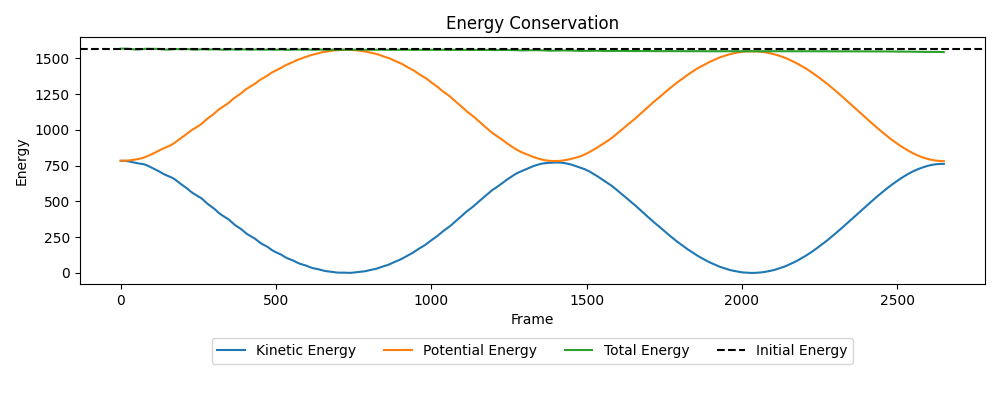

In [15]:
fig, axis = plt.subplots(1,1, figsize = (10,4), squeeze=False)

axis[0,0].plot(KEs, label = 'Kinetic Energy')
axis[0,0].plot(PEs, label = 'Potential Energy')
axis[0,0].plot(np.array(KEs) + np.array(PEs), label = 'Total Energy')
axis[0,0].axhline(KEs[0] + PEs[0], color = 'k', linestyle = '--', label = 'Initial Energy')
axis[0,0].set_xlabel('Frame')
axis[0,0].set_ylabel('Energy')
axis[0,0].set_title('Energy Conservation')

# Move the legend outside of the plot
axis[0,0].legend(bbox_to_anchor=(0.5, -0.35), loc='lower center', ncol = 4)

fig.tight_layout()

In [ ]:
potentialEnergy = 0.5 * B**2 * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2)

In [56]:
r2 = torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
v2 = torch.linalg.norm(initialVelocity, dim = -1)**2

dr = torch.linalg.norm(particleState['fluidPositions'], dim = -1) - torch.linalg.norm(perennialState['fluidPositions'], dim = -1)
dv = torch.linalg.norm(initialVelocity, dim = -1) - torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)

print(r2, v2)

print(perennialState['fluidMasses'])

print(dr, dv)
print(dr / dv)

tensor([0.3226, 0.3143, 0.3067,  ..., 0.3066, 0.3140, 0.3225], device='cuda:0') tensor([0.9982, 0.9957, 0.9933,  ..., 0.9933, 0.9957, 0.9982], device='cuda:0')
tensor([0.0990, 0.0990, 0.0990,  ..., 0.0990, 0.0990, 0.0990], device='cuda:0')
tensor([0.4311, 0.4372, 0.4429,  ..., 0.4429, 0.4375, 0.4312], device='cuda:0') tensor([0.9509, 0.9496, 0.9482,  ..., 0.9482, 0.9495, 0.9508], device='cuda:0')
tensor([0.4534, 0.4604, 0.4670,  ..., 0.4671, 0.4607, 0.4535], device='cuda:0')


In [81]:
Omega = 1
delta = 1


A = (torch.max(particleState['fluidPositions'][:,0]) - torch.min(particleState['fluidPositions'][:,0]) + config['particle']['dx']) / 2
B = (torch.max(particleState['fluidPositions'][:,1]) - torch.min(particleState['fluidPositions'][:,1]) + config['particle']['dx']) / 2

A_current = (torch.max(perennialState['fluidPositions'][:,0]) - torch.min(perennialState['fluidPositions'][:,0])) / 2
B_current = (torch.max(perennialState['fluidPositions'][:,1]) - torch.min(perennialState['fluidPositions'][:,1])) / 2

print(A, B)
print(A_current, B_current)

tensor(0.9950, device='cuda:0') tensor(0.9950, device='cuda:0')
tensor(1.8919, device='cuda:0') tensor(0.5162, device='cuda:0')


In [87]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(initialVelocity, dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(particleState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

784.545654296875
776.7586059570312


In [88]:
E_k = 0.5 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2
E_p = 0.5 * B**2 * perennialState['fluidAreas'] * perennialState['fluidDensities'] * torch.linalg.norm(perennialState['fluidPositions'], dim = -1)**2
print(E_k.sum().cpu().item())
print(E_p.sum().cpu().item())

1.4952871799468994
1527.4677734375


In [83]:
np.pi * A * B

tensor(3.1104, device='cuda:0')

In [84]:
torch.sum(perennialState['fluidAreas'])

tensor(3.1385, device='cuda:0')

In [85]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A * B * (A**2 + B**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A * B * (A**2 + B**2)

print(E_k, E_p)

tensor(769.8846, device='cuda:0') tensor(769.8846, device='cuda:0')


In [69]:
E_k = np.pi / 8 * config['fluid']['rho0'] * delta**2 * A_current * B_current * (A_current**2 + B_current**2)
E_p = np.pi / 8 * config['fluid']['rho0'] * Omega**2 * A_current * B_current * (A_current**2 + B_current**2)

print(E_k, E_p)

tensor(23598.2480, device='cuda:0') tensor(23598.2480, device='cuda:0')


In [43]:
initialVelocity = perennialState['fluidVelocities'].clone()
initialVelocity[:,0] =  A * particleState['fluidPositions'][:,0]
initialVelocity[:,1] = -A * particleState['fluidPositions'][:,1]

initialKineticEnergy = 0.5 * particleState['fluidMasses'] * (torch.linalg.norm(initialVelocity, dim = -1)**2)
initialPotentialEnergy = particleState['fluidMasses'] * B * (torch.linalg.norm(particleState['fluidPositions'], dim = -1))


kineticEnergy = 0.5 * perennialState['fluidMasses'] * (torch.linalg.norm(perennialState['fluidVelocities'], dim = -1)**2)
potentialEnergy = perennialState['fluidMasses'] * B * (torch.linalg.norm(perennialState['fluidPositions'], dim = -1))

totalInitialEnergy = initialKineticEnergy.sum() + initialPotentialEnergy.sum()
totalEnergy = kineticEnergy.sum() + potentialEnergy.sum()

print(f'Initial Energy: {totalInitialEnergy:.6g} (KE: {initialKineticEnergy.sum():.6g}, PE: {initialPotentialEnergy.sum():.6g})')
print(f'Final Energy: {totalEnergy:.6g} (KE: {kineticEnergy.sum():.6g}, PE: {potentialEnergy.sum():.6g})')
print(f'Energy difference: {totalEnergy - totalInitialEnergy:.3g} ({(totalEnergy - totalInitialEnergy) / totalInitialEnergy * 100:.3g}%)')

Initial Energy: 774.496 (KE: 154.839, PE: 619.657)
Final Energy: 774.496 (KE: 154.839, PE: 619.657)
Energy difference: 0 (0%)


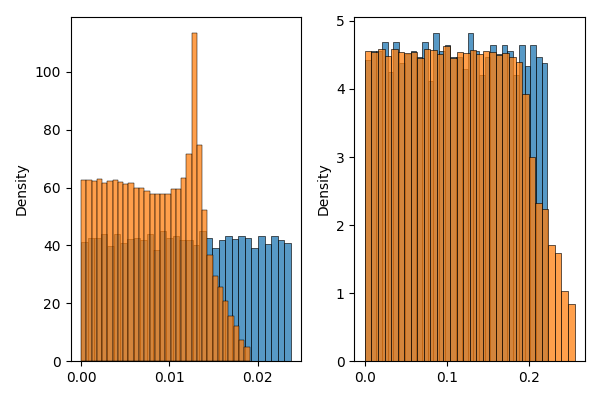

In [30]:
import seaborn as sns


fig, axis = plt.subplots(1,2, figsize = (6,4), squeeze=False)

sns.histplot(initialPotentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)
sns.histplot(potentialEnergy.cpu().numpy(), ax = axis[0,1], kde = False, stat = 'density', bins = nx//4)


sns.histplot(initialKineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)
sns.histplot(kineticEnergy.cpu().numpy(), ax = axis[0,0], kde = False, stat = 'density', bins = nx//4)



fig.tight_layout()

<img src = "./squarePatch.gif" width = 500/>